# Automatic extraction of time series features 

In order to correlate the CNN model performance with the properties of the groundwater time series, different libraries are applied ( kats, tsfresh, tsfel and tsfeatures) to rapidly obtain different parameters that allow us to understand and interpret the modeled results. 


In [4]:
%matplotlib notebook
import pandas as pd
import geopandas as gpd
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from tsfeatures import tsfeatures
#from tsfeatures import stability, series_length, flat_spots, stl_features,acf_features,pacf_features
from tsfeatures import acf_features
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tsfresh import extract_features
from pathlib import Path

In [5]:
rpath="D:/Erasmus/Thesis/data"
patht="D:/Erasmus/Thesis/"
pathg=r'D:\Erasmus\Thesis\data\resultsCNN/'
pathfig=patht+"/Figures/"

In [94]:
GWfilldatamod.GW_

Index(['wellid', 'GW_NN', 'filledtype', 'fillratio', 'fillnum'], dtype='object')

In [6]:
#Read Pickle
GWfilldatamod=pd.read_pickle(rpath+"/Pickle/GWfilldatamod2.pkl")
gw_sel_int=gpd.read_file(rpath+"/SHP/SHP2/gw_sel_intmod3.shp")


In [7]:
#Load files
folder2 = Path(pathg+"wihtoutRH/")
df = pd.concat([pd.read_csv(fname) for fname in folder2.glob("summary_CNN_*.txt")])
dfcomb=pd.concat([df.reset_index().NSE, 
                  df.reset_index().r2,df.reset_index().Bias ], axis=1)

In [8]:
#Include BIAS in the shapefile  
gw_sel_int[['bias']]=np.nan
for i in range(len(df)):
    index=gw_sel_int.loc[gw_sel_int.MEST_ID==df.wellid.values[i]].index[0]
    gw_sel_int.at[index, 'bias'] = df.Bias.values[i]

## Extract features available in TSfeatures library

__Stability , lumpiness__: Stability and lumpiness are two time series features based on tiled (non-overlapping) windows. Means or variances are produced for all tiled windows. Then stability is the variance of the means, while lumpiness is the variance of the variances.

In [25]:
#List of available features
ltsfeatures= ['hurst', 'series_length', 'unitroot_pp', 'unitroot_kpss',
       'hw_alpha', 'hw_beta', 'hw_gamma', 'stability', 'nperiods',
       'seasonal_period', 'trend', 'spike', 'linearity', 'curvature', 'e_acf1',
       'e_acf10', 'seasonal_strength', 'peak', 'trough', 'x_pacf5',
       'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1']
for i in ltsfeatures:
    gw_sel_int[i]=np.nan

### Feature extraction per well

In [27]:
cou=0
for dfraw in GWfilldatamod.GW_NN:
    
    df=dfraw[[dfraw.columns[0],dfraw.columns[-1]]]
    df["unique_id"]=[dfraw.columns[-1]]*len(df)  #give the unique code as the library requested it 
    
    #well id as an integer to search in the gw_sel file--> shapefile witht the well locations
    wellid=int(dfraw.columns[-1].split("_")[-1])
    cou+=1
    indv=gw_sel_int[gw_sel_int.MEST_ID==wellid].index[0]
    
    #Copy the dataframe to avoid modifications in the original one. 
    dfc=df.copy()
    dfc.rename(columns={dfraw.columns[0]: "ds", dfraw.columns[-1]: "y"}, inplace=True)
    feat=tsfeatures(dfc, freq=30)
    #print(feat)
    for c in ltsfeatures:
        gw_sel_int.at[indv,c]=feat[c][0] 
    
    

## Extract features available in tsfresh library

__Sample entropy__: Approximate Entropy and Sample Entropy are two algorithms for determining the regularity of series of data based on the existence of patterns. (ncbi.nlm.nih.gov/pmc/articles/PMC7515030/) 

__cid_ce__: This function calculator is an estimate for a time series complexity [1] (A more complex time series has more peaks, valleys etc.). 

__autocorrelation__:Calculates the autocorrelation of the specified lag

__Partial correlation__: is a method used to describe the relationship between two variables whilst taking away the effects of another variable, or several other variables, on this relationship.

__number_of_peaks__: Calculates the number of peaks of at least support n in the time series x. A peak of support n is defined as a subsequence of x where a value occurs, which is bigger than its n neighbours to the left and to the right.

__Lempel–Ziv complexity__ : The Lempel-Ziv complexity (LZ) is a popular tool to quantify the uncertainty contained in time series data. In particular, LZ measures how “diverse” are the patterns that are present in a particular signal. (https://information-dynamics.github.io/complexity/information/2019/06/26/lempel-ziv.html)

__Matrix profile__ : The distance profile is a vector of minimum Z-Normalized Euclidean Distances.The profile index contains the index of its first nearest-neighbor. In other words, it is the location of its most similar sub-sequence. (https://towardsdatascience.com/introduction-to-matrix-profiles-5568f3375d90) 

In [19]:
#List of features with high-correlation according to previous checks
lfeatures=['y__longest_strike_below_mean','y__longest_strike_above_mean',
           'y__fourier_entropy__bins_3',
            'y__sample_entropy', 'y__cid_ce__normalize_True', 
            'y__autocorrelation__lag_6', 
            'y__lempel_ziv_complexity__bins_3','y__partial_autocorrelation__lag_3', 
            'y__number_peaks__n_10', 'y__approximate_entropy__m_2__r_0.5']

In [50]:

for dfraw in GWfilldatamod.GW_NN:
    df=dfraw[[dfraw.columns[0],dfraw.columns[-1]]]
    df["id"]=[dfraw.columns[-1]]*len(df)  #give the unique code as the library requested it 
    
    #well id as an integer to search in the gw_sel file--> shapefile witht the well locations
    wellid=int(dfraw.columns[-1].split("_")[-1])
    indv=gw_sel_int[gw_sel_int.MEST_ID==wellid].index[0]
    
    #Copy the dataframe to avoid modifications in the original one. 
    dfc=df.copy()
    dfc.rename(columns={dfraw.columns[0]: "time", dfraw.columns[-1]: "y"}, inplace=True)
    feat=extract_features(dfc, column_id="id", column_sort="time")
    
    for c in lfeatures:
        gw_sel_int.at[indv,c]=feat[c][0] 

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


## Extract Pearson/Spearmann coefficient

In [39]:
#Join list of features
ltsfeatures= ['hurst', 'series_length', 'unitroot_pp', 'unitroot_kpss',
       'hw_alpha', 'hw_beta', 'hw_gamma', 'stability',
        'trend', 'spike', 'linearity', 'curvature', 'e_acf1',
       'e_acf10', 'seasonal_strength', 'peak', 'trough', 'x_pacf5',
       'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1']
lfeatures=['y__longest_strike_below_mean','y__longest_strike_above_mean',
              'y__fourier_entropy__bins_3',
                'y__sample_entropy',  'y__autocorrelation__lag_6', 
               'y__lempel_ziv_complexity__bins_3','y__partial_autocorrelation__lag_3', 
               'y__number_peaks__n_10', 'y__approximate_entropy__m_2__r_0.5']
all_features=ltsfeatures
gw_sel_int[all_features]

,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,trend,spike,...,entropy,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,0.524698,592.0,-143.830994,0.050150,1.000000,0.000000e+00,3.295723e-11,0.082573,0.134237,2.803218e-06,...,0.661337,121.0,0.403149,0.778912,1.300091,0.123129,0.295877,-0.462058,0.237254,-0.437108
1,0.504174,476.0,-160.706579,0.133445,1.000000,0.000000e+00,5.164489e-11,0.059715,0.071331,4.463275e-06,...,0.647990,97.0,0.153363,0.696476,1.400176,-0.012067,0.192453,-0.514486,0.281951,-0.535319
2,0.698245,379.0,-75.562153,0.244431,1.000000,0.000000e+00,3.114622e-09,0.098787,0.290659,5.253964e-06,...,0.668126,65.0,0.654174,0.859137,1.432362,0.265293,0.431828,-0.363838,0.160186,-0.374308
3,0.558150,573.0,-124.636950,0.086505,1.000000,3.688113e-11,1.091830e-17,0.121807,0.211958,2.609696e-06,...,0.665504,110.0,0.666727,0.813191,1.264644,0.180365,0.376999,-0.473410,0.246860,-0.393054
4,0.749401,598.0,-128.927288,0.604780,1.000000,1.406811e-09,5.818204e-09,0.169460,0.219871,1.717146e-06,...,0.603198,110.0,0.427798,0.810946,1.272260,0.250495,0.426124,-0.339759,0.189474,-0.417612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.614300,278.0,-79.186683,0.245223,1.000000,1.055466e-10,1.983808e-10,0.106293,0.110449,1.070879e-05,...,0.520488,56.0,0.260831,0.771908,1.474889,0.191242,0.318903,-0.384534,0.166607,-0.479030
501,0.654545,256.0,-58.382461,0.499193,1.000000,2.504915e-11,6.414615e-09,0.133299,0.215428,5.599609e-06,...,0.616851,40.0,0.547763,0.842864,1.387621,0.334314,0.598572,-0.359699,0.233810,-0.213675
502,0.683358,256.0,-47.566807,0.635740,1.000000,9.576380e-01,5.652520e-11,0.188779,0.308242,4.823691e-06,...,0.600448,35.0,0.752078,0.896518,1.535185,0.614359,1.179885,-0.006477,0.106990,-0.080863
503,0.746526,564.0,-42.493100,1.602840,1.000000,8.356503e-01,4.963797e-11,0.418150,0.687198,8.449697e-07,...,0.529398,36.0,0.856841,0.959835,4.359315,0.560481,0.834713,-0.124419,0.085583,-0.117699


In [30]:
def bootstrap(nsamp,gw):
    vindex=[]
    for k in range(nsamp): 
        index=np.random.randint(0,len(gw), len(gw))
        vindex.append(index)
    return vindex

In [40]:
#_2 means only using P and T as input variables 
perfor=[ 'r2_2', 'NSE_2', 'bias']

#Create dataframe to store the correlations
lzero=np.zeros(len(all_features))
d = {'variable': all_features,'r2_2':lzero, 'NSE_2':lzero, 'bias': lzero}
dfrval = pd.DataFrame(data=d)
#gw_sel_intc=gw_sel_int.copy()

for p in perfor:
    lrvalue = []
    
    vindex=bootstrap(1000, gw_sel_int[p])
    
    for col in all_features:
        vlrvalue= []
        for i in vindex:
            slope, intercept, r_value, p_value, std_err = stats.linregress(gw_sel_int[col][i], 
                                                                           gw_sel_int[p][i])
            vlrvalue.append(round(r_value,2)) if p_value <= 0.1 else vlrvalue.append(0) 
            
        # add only the correlations that are statistically significant
        lrvalue.append(round(np.nanmean(vlrvalue),2)) 
                         
    dfrval[p]=lrvalue


In [41]:
dfrvalcc=dfrval.copy()
dfrvalcc.rename(columns={"r2_2":"r$^2$","NSE_2":"NSE", "bias":"BIAS"}, inplace=True)

In [93]:
dictionary={
            'series_length': 'Series length', 
            'stability': 'Stability',
            'trend':  'Seasonal trend', 
            'seasonal_strength':'Seasonal strength', 
            'flat_spots': 'Flat spots',  
            'x_acf10': 'Sum of squares of autocorrelation coefficients', 
            'seas_acf1': 'Seasonal autocorrelation', 
            'y__longest_strike_below_mean': 'Longest strike below mean',
            'y__longest_strike_above_mean': 'Longest strike above mean',
            'y__fourier_entropy__bins_3': 'Fourier entropy',
            'y__sample_entropy': 'Sample entropy', 
            'y__autocorrelation__lag_6':'Autocorrelation', 
            'y__lempel_ziv_complexity__bins_3': 'Lempel ziv complexity',
            'y__partial_autocorrelation__lag_3':'Partial autocorrelation', 
            'y__number_peaks__n_10': 'Number of peaks',
            'y__approximate_entropy__m_2__r_0.5': 'Approximate entropy'
}

dictionary2={
            'Seasonal autocorrelation':1, 'Seasonal strength':4, 'Autocorrelation':-1,
       'Partial autocorrelation':0, 'Flat spots':6, 'Stability':3, 'Seasonal trend':5,
       'Longest strike below mean':7, 'Fourier entropy':9,
       'Longest strike above mean':8, 
       'Sum of squares of autocorrelation coefficients':2, 'Sample entropy':12,
       'Approximate entropy':13, 'Lempel ziv complexity':14, 'Series length':11,
       'Number of peaks':15
}

dfrvalcc["variables_d"]=dfrvalcc['variable'].map(dictionary)
dfrvalcc["order"]=dfrvalcc['variables_d'].map(dictionary2)

In [64]:
#dfrvalccf1=dfrvalcc.sort_values(by="order")
dfrvalccf2=dfrvalcc.set_index('variable')
dfrvalccf=dfrvalccf2[dfrvalccf2.columns[:]]

In [90]:
dff=dfrvalccf[dfrvalccf["r$^2$"].abs() > 0.2].dropna()

In [91]:
%matplotlib inline
pathfig=r"D:\FOSTER\Figs/"

Text(45.58159722222221, 0.5, ' ')

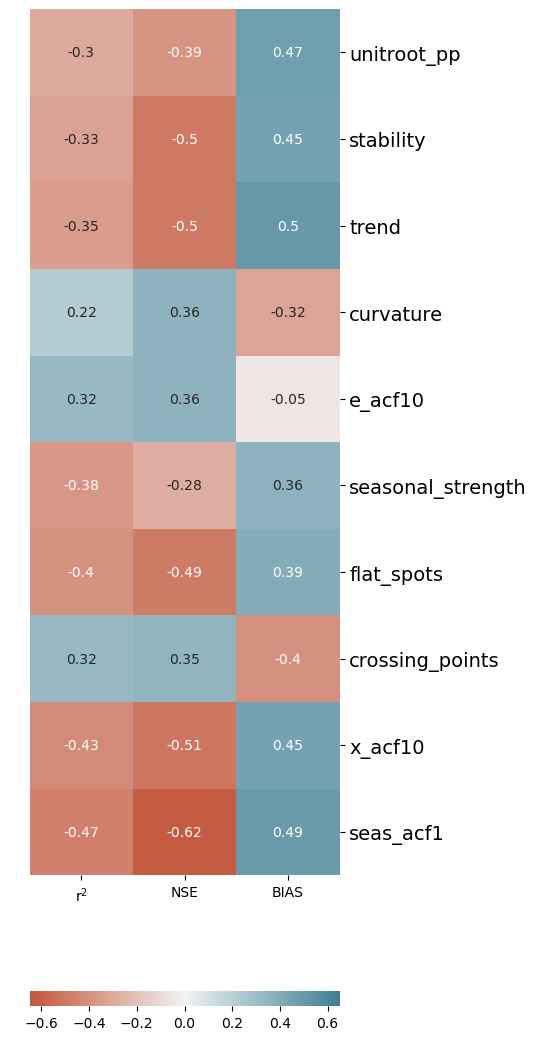

In [92]:
fig = plt.figure(figsize=(6,15))
cmap = sns.diverging_palette(20, 220, as_cmap=True)
ax= sns.heatmap(dff, annot=True,cmap=cmap, center=0,  annot_kws={"size":10}, vmin=-.65, vmax=.65, 
                cbar=False)
ax.tick_params(axis='y', left=False, right=True, labelright=True, labelleft =False, labelrotation=0,
              labelsize=14)
#plt.legend(loc='lower center')
cbar = ax.figure.colorbar(ax.collections[0], orientation='horizontal', pad=0.1)
cbar.outline.set_visible(False)
fig.set_size_inches(4, 15)
plt.ylabel(' ')
#plt.tight_layout()
#plt.savefig(pathfig+'matrixts2.pdf')